In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import time
import os
from google.colab import drive

In [ ]:
def image_pre_processing(path, show_image = True):
  img_size = (512, 512)
  image = tf.io.read_file(path)
  image = tf.image.decode_image(image, channels = 3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, img_size)
  if show_image: 
    plt.imshow(image.numpy())
  return image

In [ ]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

196608/195196 [==============================] - 0s 0us/step


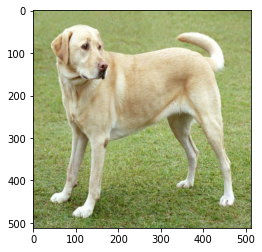

In [ ]:
content_img = image_pre_processing(content_path, show_image = True)

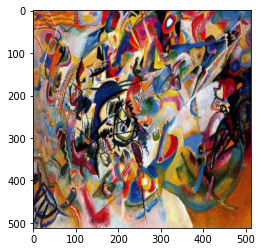

In [ ]:
style_img = image_pre_processing(style_path, show_image = True)

In [ ]:
preprocessed_content = tf.keras.applications.vgg19.preprocess_input(content_img*255)
preprocessed_style = tf.keras.applications.vgg19.preprocess_input(style_img*255)

In [ ]:
vgg19 = tf.keras.applications.VGG19(include_top=False)
vgg19.trainable = False

80142336/80134624 [==============================] - 2s 0us/step


In [ ]:
def loss_function(preprocessed_content, preprocessed_style, target_img, alpha=1e-2, beta=1e-2):
  
  content_layers = ['block5_conv2'] 
  style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

  content_model = tf.keras.Model([vgg19.input], [vgg19.get_layer(layer).output for layer in content_layers])
  style_model = tf.keras.Model([vgg19.input], [vgg19.get_layer(layer).output for layer in style_layers])

  preprocessed_target = tf.keras.applications.vgg19.preprocess_input(target_img*255)
  
  content_features = content_model(tf.expand_dims(preprocessed_content, axis=0))
  target_content_features = content_model(tf.expand_dims(preprocessed_target, axis=0))

  style_features = style_model(tf.expand_dims(preprocessed_style, axis=0))
  target_style_features = style_model(tf.expand_dims(preprocessed_target, axis=0))

  content_loss = tf.math.reduce_mean(tf.math.square(target_content_features - content_features))

  E = []
  for l in range(len(style_features)):
    N = style_features[l].shape[-1]
    M = tf.math.reduce_prod(style_features[l].shape[:-1]).numpy()
    style_features_reshaped = tf.reshape(style_features[l], [M, N])
    A = tf.matmul(style_features_reshaped, style_features_reshaped, transpose_a=True)
    target_style_features_reshaped = tf.reshape(target_style_features[l], [M, N])
    G = tf.matmul(target_style_features_reshaped, target_style_features_reshaped, transpose_a=True)
    E.append(tf.math.reduce_mean(tf.math.square(G - A)))
  style_loss = sum(E) / len(E)

  total_loss = alpha * content_loss + beta * style_loss
  return total_loss

In [ ]:
def vgg19_neural_style_transfer(content_img, style_img, 
                                preprocessed_content, preprocessed_style, 
                                opt = tf.optimizers.Adam(learning_rate = 0.1), 
                                steps = 100, 
                                alpha = 1, 
                                beta = 1e-14,
                                seed = 5243, 
                                display_content = True, 
                                display_style = True, 
                                display_target = True):
  


  if display_content: 
    plt.figure(); plt.imshow(content_img.numpy()); plt.title('Content Image'); 

  if display_style: 
    plt.figure(); plt.imshow(style_img.numpy()); plt.title('Style Image'); 

  if display_target: 
    tf.random.set_seed(seed)
    target_img = tf.Variable(content_img)

    start = time.time()
    losses = []
    for i in range(steps):
      if i%10==0:
        print(i)
      with tf.GradientTape() as tape:
        loss = loss_function(preprocessed_content = preprocessed_content, 
                             preprocessed_style = preprocessed_style, 
                             target_img = target_img, 
                             alpha = alpha, 
                             beta = beta)
      losses.append(loss)
      grad = tape.gradient(loss, target_img)
      opt.apply_gradients([(grad, target_img)])
      target_img.assign(tf.clip_by_value(target_img, 0.0, 1.0))
    losses.append(loss_function(preprocessed_content = preprocessed_content, 
                                preprocessed_style = preprocessed_style, 
                                target_img = target_img, 
                                alpha = alpha, beta = beta))
    end = time.time()
    plt.figure(figsize = (10, 10)); plt.imshow(target_img.numpy()); 
    print("Total time: {:.1f}".format(end - start))
    return losses


In [ ]:
# tf.config.run_functions_eagerly(True)

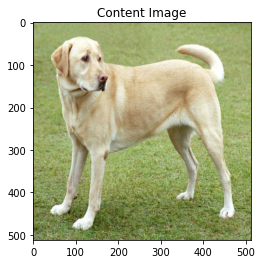

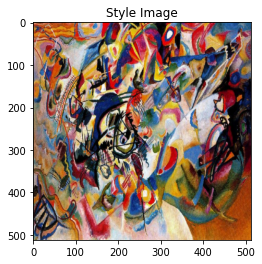

In [ ]:
vgg19_neural_style_transfer(content_img = content_img, style_img = style_img, 
                            preprocessed_content = preprocessed_content, preprocessed_style = preprocessed_style,
                            display_target = False)

0
10
20
30
40
50
60
70
80
90
Total time: 36.8


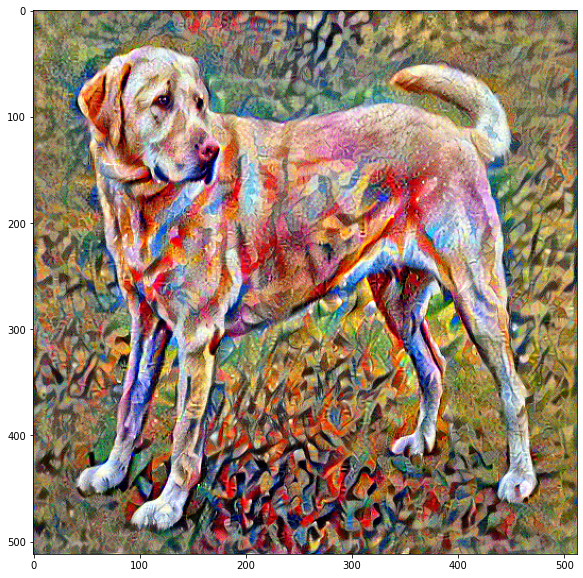

In [ ]:
#tf.random.set_seed(0)
trial1 = vgg19_neural_style_transfer(content_img = content_img, style_img = style_img, 
                                     preprocessed_content = preprocessed_content, preprocessed_style = preprocessed_style,
                                     display_content = False, display_style = False)

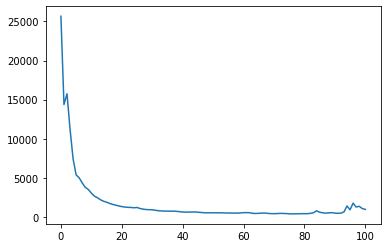

In [ ]:
plt.plot(trial1)

0
10
20
30
40
50
60
70
80
90
Total time: 30.3


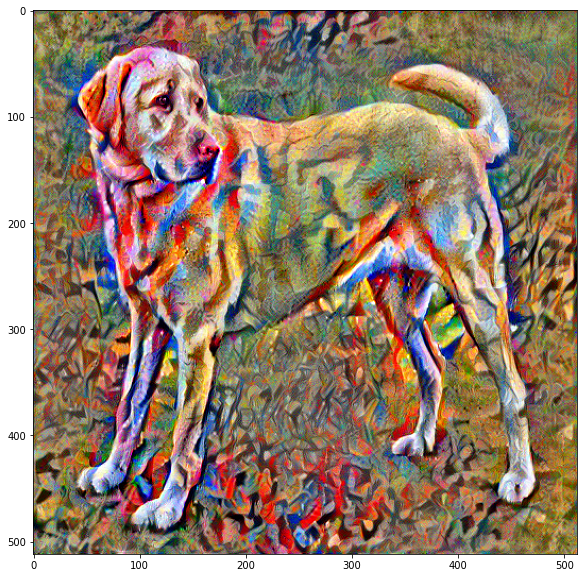

In [ ]:
#tf.random.set_seed(0)
trial2 = vgg19_neural_style_transfer(content_img = content_img, style_img = style_img,  
                                     preprocessed_content = preprocessed_content, preprocessed_style = preprocessed_style,
                                     display_content = False, display_style = False)

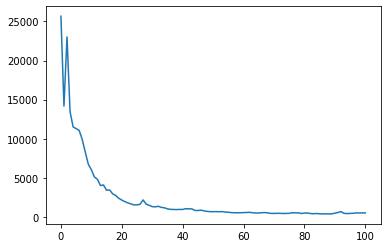

In [ ]:
plt.plot(trial2)

0
10
20
30
40
50
60
70
80
90
Total time: 30.3


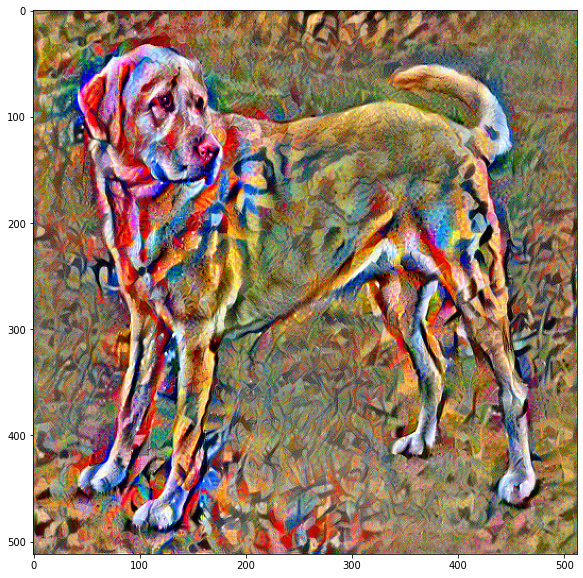

In [ ]:
trial3 = vgg19_neural_style_transfer(content_img = content_img, style_img = style_img, 
                                     preprocessed_content = preprocessed_content, preprocessed_style = preprocessed_style,
                                     display_content = False, display_style = False)

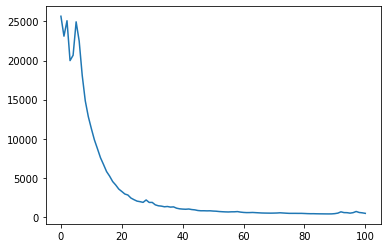

In [ ]:
plt.plot(trial3)

0
10
20
30
40
50
60
70
80
90
Total time: 30.3


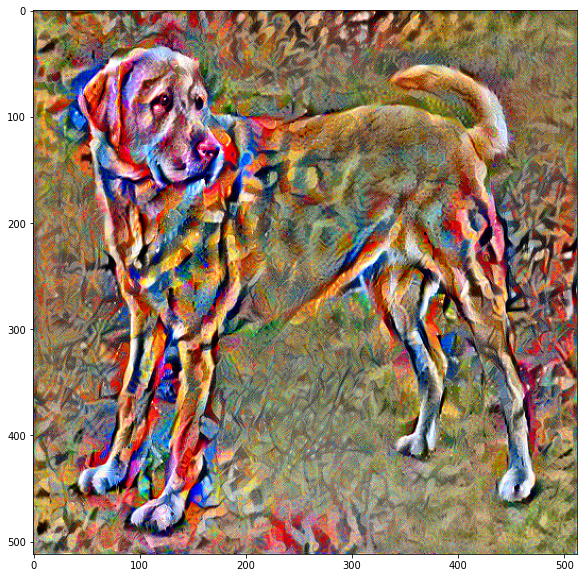

In [ ]:
trial4  = vgg19_neural_style_transfer(content_img = content_img, style_img = style_img, 
                                     preprocessed_content = preprocessed_content, preprocessed_style = preprocessed_style,
                                     display_content = False, display_style = False)

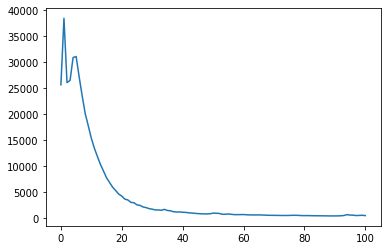

In [ ]:
plt.plot(trial4)

0
10
20
30
40
50
60
70
80
90
Total time: 30.3


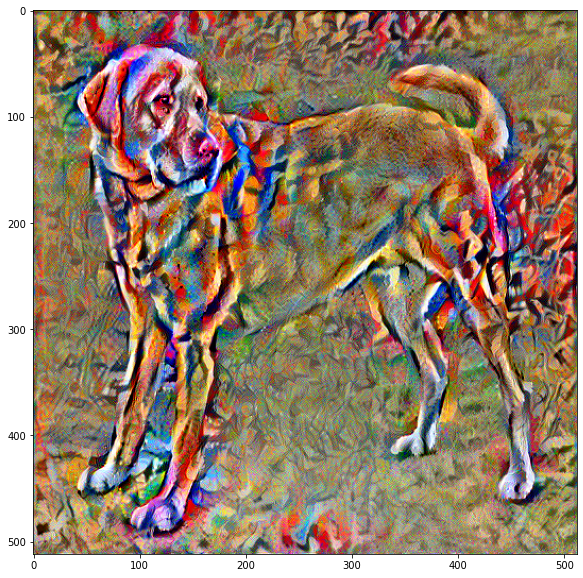

In [ ]:
trial5  = vgg19_neural_style_transfer(content_img = content_img, style_img = style_img, 
                                     preprocessed_content = preprocessed_content, preprocessed_style = preprocessed_style,
                                     display_content = False, display_style = False)

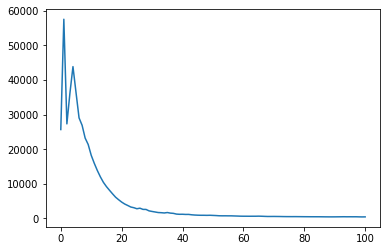

In [ ]:
plt.plot(trial5)